In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def rk4_step(state, f, dt, *args):
    '''
    state: a tuple that include all nodes of each variable.
    f: the specific expression of the equation, the expression of the time derivative.
    dt: time step
    '''

    # k1
    k1 = f(state, *args)
    # add dt/2*k1 to each component of state
    state_k1 = tuple(s + 0.5 * dt * k for s, k in zip(state, k1))

    # k2
    k2 = f(state_k1, *args)
    # add dt/2*k2 to each component of state
    state_k2 = tuple(s + 0.5 * dt * k for s, k in zip(state, k2))

    # k3
    k3 = f(state_k2, *args)
    # add dt * k3 to each component of state
    state_k3 = tuple(s + dt* k for s, k in zip(state, k3))

    # k4
    k4 = f(state_k3, *args)

    # update
    new_state = tuple(
        s + (dt/6.0) * (k1_i + 2*k2_i + 2*k3_i + k4_i)
        for s, k1_i, k2_i, k3_i, k4_i in zip(state, k1, k2, k3, k4)
    )

    return new_state

def wave_equation(state, c, dx):
    u, v = state
    N = len(u) - 1

    du_dt = np.zeros_like(u)
    dv_dt = np.zeros_like(v)

    for i in range(1, N):
        du_dt[i] = v[i]
        dv_dt[i] = c**2 * (u[i+1] - 2*u[i] + u[i-1]) / dx**2

    # Fixed boundary condition
    # du_dt[0] = 0.0
    # dv_dt[0] = 0.0
    # du_dt[N] = 0.0
    # dv_dt[N] = 0.0

    # Periodic boundary condition
    du_dt[0] = v[0]
    dv_dt[0] = c**2 * (u[1] - 2*u[0] + u[N]) / dx**2

    du_dt[N] = v[N]
    dv_dt[N] = c**2 * (u[0] - 2*u[N] + u[N-1]) / dx**2

    return (du_dt, dv_dt)

def coupled_wave_equations(state, c1, c2, a1, a2, b1, dx):
    u1, v1, u2, v2 = state
    N = len(u1) - 1

    du1_dt = np.zeros_like(u1)
    du2_dt = np.zeros_like(u1)
    dv1_dt = np.zeros_like(u2)
    dv2_dt = np.zeros_like(u2)

    for i in range(1, N):
        du1_dt[i] = v1[i]
        # dv1_dt[i] = (c1**2 * (u1[i+1] - 2*u1[i] + u1[i-1]) / dx**2) + a1 * (u2[i+1] - u2[i-1]) / (2 * dx)
        dv1_dt[i] = (c1**2 * (u1[i+1] - 2*u1[i] + u1[i-1]) / dx**2) + a1 * (u2[i+1] - u2[i-1]) / (2 * dx) + b1*u2[i]**2

        du2_dt[i] = v2[i]
        dv2_dt[i] = (c2**2 * (u2[i+1] - 2*u2[i] + u2[i-1]) / dx**2) + a2 * (u1[i+1] - u1[i-1]) / (2 * dx)
    
    du1_dt[0] = 0
    dv1_dt[0] = 0
    du2_dt[0] = 0
    dv2_dt[0] = 0
    du1_dt[N] = 0
    dv1_dt[N] = 0
    du2_dt[N] = 0
    dv2_dt[N] = 0

    return (du1_dt, dv1_dt, du2_dt, dv2_dt)

In [2]:
def coupled_soliton_wave_equations(state, K, theta0, alpha, dx):
    u, v, theta, phi = state    # phi is the time derivative of theta
    N = len(u) - 1

    du_dt = np.zeros_like(u)
    dv_dt = np.zeros_like(u)
    dtheta_dt = np.zeros_like(theta)
    dphi_dt = np.zeros_like(phi)

    for i in range(1, N):
        du_dt[i] = v[i]
        dv_dt[i] = (u[i+1] - 2*u[i] + u[i-1]) / dx**2 + (1 - K) * np.tan(theta0) * (theta[i+1] - theta[i-1]) / (2*dx)
        dtheta_dt[i] = phi[i]
        dphi_dt[i] = alpha**2 * ((np.cos(2 * theta0) - K) * (theta[i+1] - 2*theta[i] + theta[i-1]) / dx**2 
                               - 2 * np.sin(2 * theta0) * (u[i+1] - u[i-1]) / (2*dx) 
                               - 4 * (2*K + np.cos(theta0)**2 * (u[i+1] - u[i-1]) / (2 * dx) + 2 * np.sin(theta0)**2) * theta[i] 
                               - 4 * np.sin(2 * theta0) * theta[i]**2)
        
    # No boundary condition
    du_dt[0] = v[0]
    dv_dt[0] = (u[1] - u[0]) / dx**2 + (1 - K) * np.tan(theta0) * (theta[1] - theta[0]) / (2*dx)
    dtheta_dt[0] = phi[0]
    dphi_dt[0] = alpha**2 * ((np.cos(2 * theta0) - K) * (theta[1] - theta[0]) / dx**2 
                               - 2 * np.sin(2 * theta0) * (u[1] - u[0]) / (2*dx) 
                               - 4 * (2*K + np.cos(theta0)**2 * (u[1] - u[0]) / (2 * dx) + 2 * np.sin(theta0)**2) * theta[0] 
                               - 4 * np.sin(2 * theta0) * theta[0]**2)
    du_dt[N] = v[N]
    dv_dt[N] = (-u[N] + u[N-1]) / dx**2 + (1 - K) * np.tan(theta0) * (theta[N] - theta[N-1]) / (2*dx)
    dtheta_dt[N] = phi[N]
    dphi_dt[N] = alpha**2 * ((np.cos(2 * theta0) - K) * (-theta[N] + theta[N-1]) / dx**2 
                               - 2 * np.sin(2 * theta0) * (u[N] - u[N-1]) / (2*dx) 
                               - 4 * (2*K + np.cos(theta0)**2 * (u[N] - u[N-1]) / (2 * dx) + 2 * np.sin(theta0)**2) * theta[N] 
                               - 4 * np.sin(2 * theta0) * theta[N]**2)
    
    return (du_dt, dv_dt, dtheta_dt, dphi_dt)

In [42]:
m = 2.093e-3
J = 18.11e-9
k = 19235
k_theta = 0.0427
l = 11.3e-3 / 2
K = k_theta / (k * l**2)
alpha = l / (np.sqrt(J / m))
theta0 = np.pi / 180 * 25

1.1 / np.sqrt(k / m) / 2 / l /np.cos(theta0)
0.004 / 2/l/np.cos(theta0)
# Length
L = 40.0
# Mesh points
N = 400
dx = L/N
x = np.linspace(0, L, N+1)

dt = 0.01
num_steps = 5000


np.float64(3.29866732706564e-06)

Step = 0, finished
Step = 1, finished
Step = 2, finished
Step = 3, finished
Step = 4, finished
Step = 5, finished
Step = 6, finished
Step = 7, finished
Step = 8, finished
Step = 9, finished
Step = 10, finished
Step = 11, finished
Step = 12, finished
Step = 13, finished
Step = 14, finished
Step = 15, finished
Step = 16, finished
Step = 17, finished
Step = 18, finished
Step = 19, finished
Step = 20, finished
Step = 21, finished
Step = 22, finished
Step = 23, finished
Step = 24, finished
Step = 25, finished
Step = 26, finished
Step = 27, finished
Step = 28, finished
Step = 29, finished
Step = 30, finished
Step = 31, finished
Step = 32, finished
Step = 33, finished
Step = 34, finished
Step = 35, finished
Step = 36, finished
Step = 37, finished
Step = 38, finished
Step = 39, finished
Step = 40, finished
Step = 41, finished
Step = 42, finished
Step = 43, finished
Step = 44, finished
Step = 45, finished
Step = 46, finished
Step = 47, finished
Step = 48, finished
Step = 49, finished
Step = 50,

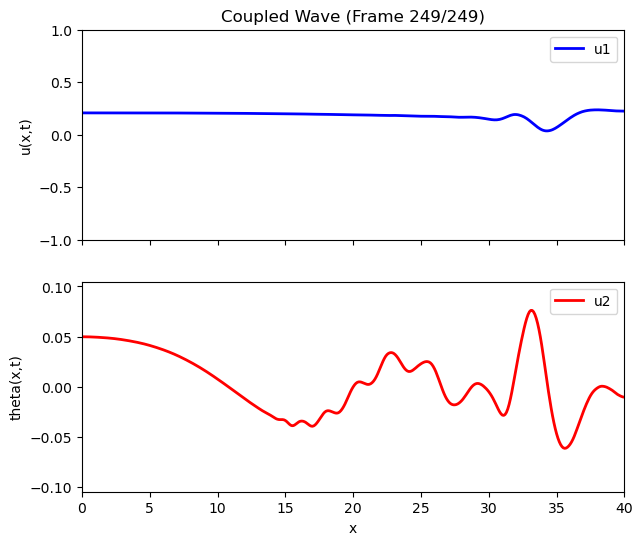

In [43]:
# Length
L = 40.0
# Mesh points
N = 400
dx = L/N
x = np.linspace(0, L, N+1)

dt = 0.01
num_steps = 5000

m = 2.093e-3
J = 18.11e-9
k = 19235
k_theta = 0.0427
l = 11.3e-3 / 2


K = k_theta / (k * l**2)
alpha = l / (np.sqrt(J / m))
theta0 = np.pi / 180 * 25

x0 = 0
sigma = 1
u_init = 0.4 * np.exp( -((x - x0)**2) / (2*sigma**2) )
v_init = 0.035 * np.exp( -((x - x0)**2) / (2*sigma**2) )
# theta_init = np.pi/90 * np.exp( -((x - x0)**2) / (2*sigma**2) )
theta_init = np.zeros_like(x)
phi_init = np.zeros_like(x)

state = (u_init, v_init, theta_init, phi_init)

# 3.5. We'll store snapshots for animation
snapshots_u = []
snapshots_theta = []

# how often to store frames
store_interval = 20

for step in range(num_steps):
    # Evolve one step with RK4
    print(f"Step = {step}, finished")
    state = rk4_step(state, coupled_soliton_wave_equations, dt, K, theta0, alpha, dx)
    
    # Save frames periodically
    if step % store_interval == 0:
        (u_snap, v_snap, theta_snap, phi_snap) = state
        snapshots_u.append(u_snap.copy())
        snapshots_theta.append(theta_snap.copy())

# 3.6. Build the animation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,6), sharex=True)

# line objects for u1, u2
line1, = ax1.plot([], [], 'b-', lw=2, label="u1")
line2, = ax2.plot([], [], 'r-', lw=2, label="u2")

# Basic axis limits
ax1.set_xlim(0, L)
ax1.set_ylim(-1, 1)
ax2.set_xlim(0, L)
ax2.set_ylim(-np.pi/30, np.pi/30)

ax1.set_ylabel("u(x,t)")
ax2.set_ylabel("theta(x,t)")
ax2.set_xlabel("x")

ax1.set_title("Coupled Wave Equation: u1 & u2 evolution")
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")

# init function
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1, line2)

# animation update
def animate(frame_idx):
    line1.set_data(x, snapshots_u[frame_idx])
    line2.set_data(x, snapshots_theta[frame_idx])
    ax1.set_title(f"Coupled Wave (Frame {frame_idx}/{len(snapshots_u)-1})")
    return (line1, line2)

ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(snapshots_u), interval=50, blit=True
)

# 3.7. Save to GIF
ani.save("coupled_wave_bolei_soliton.gif", writer='pillow', fps=20)

plt.show()